In [4]:
import numpy as np
import pandas as pd

# <font color = "blue"> Self Assessment: Simulated Annealing for Gerrymandering </font>

In [6]:
# set the data and define the objective function
num_districts = 10
min_voters_in_district = 150
max_voters_in_district = 350
num_cities = 18

dems = [152,81,75,34,62,38,48,74,98,66,83,86,72,28,112,45,93,72]
reps = [62,59,83,52,87,87,69,49,62,72,75,82,83,53,98,82,68,98]
cities = pd.DataFrame( data = {'dems':dems, 'reps':reps})

# same as in Lesson 4
def fitness_districts(assign, cities):
    df = cities.groupby(assign).sum()
    fitness = sum( df['reps'] > df['dems'] )
    total_voters = np.zeros(num_districts,dtype=np.int32)
    total_voters[df.index] = df.sum(axis=1)
    fitness-= np.abs(np.minimum(np.maximum(total_voters,150),350)-total_voters).sum()
    return fitness # we return a tuple with the fitness

# for printing out an assignment of cities to districts
def summarize_districts(assign, cities):
    reps = np.zeros(num_districts, dtype=np.int32)
    dems = np.zeros(num_districts, dtype=np.int32)
    df = cities.groupby(assign).sum()
    reps[df.index] = df['reps']
    dems[df.index] = df['dems']
    total = reps + dems
    delta = np.minimum(np.maximum(total, min_voters_in_district),
                       max_voters_in_district) - total
    rep_win = reps > dems
    dict = {
        'reps': reps,
        'dems': dems,
        'total': total,
        'rep_win': rep_win
    }
    return (pd.DataFrame(data=dict))

In [17]:
# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]


# define objective function
def tour_distance(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance


def sub_tour_reversal(tour):
    # reverse a random tour segment
    i, j = np.sort(np.random.choice(individual_size, 2, replace=False))
    swapped = np.concatenate((tour[0:i], tour[j:-individual_size + i - 1:-1],
                              tour[j + 1:individual_size]))
    return [int(swapped[i]) for i in range(individual_size)]


max_moves_no_improve = 1000
max_iter = 5000
temp = 50
alpha = 0.99
best_fitness = -10000000

assign = np.random.randint(low=0,high=num_districts,size = 18) # random starting points
current_fitness = fitness_districts(assign,cities)

iteration = 1
num_moves_no_improve = 0
while (num_moves_no_improve < max_moves_no_improve and iteration < max_iter):

    num_moves_no_improve += 1
    new_assign = assign.copy()
    # randomly choose a city and assign it to a random district
    new_assign[ np.random.randint(18)] = np.random.randint(10)
    new_fitness = fitness_districts(new_assign,cities)
    delta = new_fitness-current_fitness # new-current for maximization
    prob = np.exp(min(delta, 0) / temp)
    accept = new_fitness > current_fitness or np.random.uniform() < prob

    if accept:
        current_assign= new_assign
        current_fitness = new_fitness
        if current_fitness > best_fitness:
            best_assign = current_assign
            best_fitness = current_fitness
            num_moves_no_improve = 0
    temp *= alpha
    iteration += 1

summarize_districts(best_assign, cities)

,reps,dems,total,rep_win
0,181,144,325,True
1,265,264,529,True
2,98,112,210,False
3,154,152,306,True
4,69,48,117,True
5,257,175,432,True
6,111,115,226,False
7,62,152,214,False
8,75,83,158,False
9,49,74,123,False


/Users/jbaggett/anaconda3/envs/ds775/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/jbaggett/anaconda3/envs/ds775/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


<IPython.core.display.Javascript object>


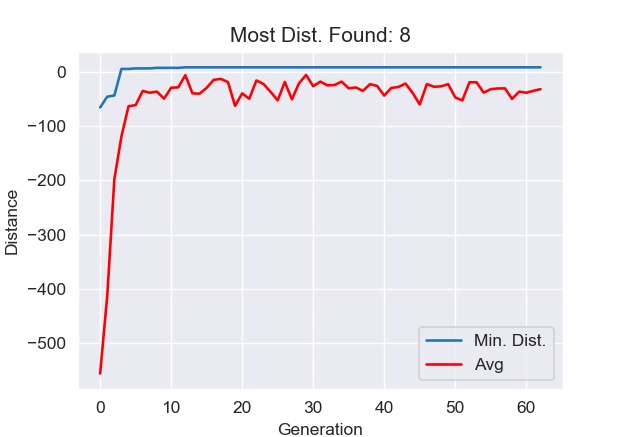

Text(0.5, 1.0, 'Most Dist. Found: 8')

In [95]:
individual_size =num_cities

# create a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(1.0, ))
# tells us what kind of individuals we'll have - arrays of integers
creator.create("Individual",list,fitness=creator.FitnessMin)

# configure toolbox
toolbox = base.Toolbox()
# define how we create an individual and a population
def create_individual(nd,nc):
    return random.choices(range(nd),k=nc)
toolbox.register("indices",create_individual,num_districts,individual_size)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# register the fitness function
# notice we are registering the distance matrix from above as an extra argument
toolbox.register("evaluate", fitness_districts, cities=cities)
# register selection operator
toolbox.register("select", tools.selTournament, tournsize=8)
# register crossover operator
toolbox.register("mate", tools.cxOnePoint)
# register mutation opperator
toolbox.register("mutate", tools.mutUniformInt, low = 0, up=num_districts-1, indpb=0.05)

# configure statistics to collect
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# define search parameters
pop_size = 50
crossover_prob = .8
mutation_prob = .5
max_gen = 500
max_no_improve = 50

# get solution
best_dist, best_tour, log = customGA(pop_size, crossover_prob, mutation_prob,
                                     max_gen, max_no_improve)

# plot search convergence
fig = plt.figure(figsize=(5, 3.5))
line_best, = plt.plot(log.select('gen'), log.select('max'), label='Best')
line_avg, = plt.plot(log.select('gen'),
                     log.select('avg'),
                     color='red',
                     label='Avg')
#line_max, = plt.plot(log.select('gen'),log.select('max'),color='green',label='Max. Val.')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_min, line_avg])
plt.title('Most Dist. Found: {:d}'.format(int(best_dist)))

In [ ]:
toolbox.register("mutate", tools.mutUniformInt, low = 0, up=num_districts-1, indpb=0.05)